# Path following for car-like robots

* deomonstrate the interfacing
* try also tuning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mrobotics.models.motion.simulator import kinematic_car_simulator
from mrobotics.piecewise.cubic import interpolating_path2d
from mrobotics.models.footprint import footprint_rectangle # for extra fancy visualization
from mrobotics.piecewise.waypoints_maker import gen_s_curve

from mrobotics.motion_ctr.cars.path_following import stanley_path_follower
from mrobotics.models.motion.kinematic import calc_xy_front_axle

## Simulation/ test setup

* set_speed --- for simplicity, consider it to be a constant (throughout each simulation).
* path
* plant model

In [2]:
set_speed = 40.0/3.6 # m/s (pretaining to the progress of the vehicle's reference point along the path!)
print(f"set speed : {set_speed:.2f} m/s")

set speed : 11.11 m/s


In [3]:
wheelbase = 1.8
steering_max = np.deg2rad(45) # so far only used in the controller, not in the simulator yet
footprint = footprint_rectangle(xf=2.5, xr = 0.7, width=1.6)

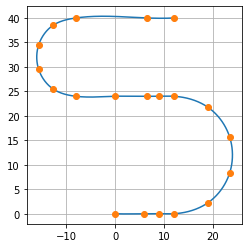

Simulation duration: 10.24 sec


In [4]:
r1 = 12.0
r2 = 8.0
task_waypts = gen_s_curve(r1,r2)
my_curve = interpolating_path2d(task_waypts) # tried with success
my_curve.viz()
plt.show()

sim_duration = my_curve.get_tot_dist()/set_speed
# sim_duration = 20
print(f"Simulation duration: {sim_duration:.2f} sec")

In [5]:
# state vector ordering (repeated from the docstring of kinematic_car_simulator)
# 0. X
# 1. Y
# 2. Yaw
# 3. actual steering angle
# 4. actual longitudinal velocity (a signed quantity!)

initial_state = np.array([0,0,-np.deg2rad(10), -np.pi/10, 0.001])
# crashing
# initial_state = np.array([0,0,-np.pi/3, -np.pi/10, 0.0]) # try to be initially stationary

# construct a simulator
sim_step_sz = 0.02
plant_simulator = kinematic_car_simulator(
    step_sz=sim_step_sz, sim_duration= sim_duration,  # 0.02 sec found to be sufficient (tried also 0.001 which leads to almost identical simulated trajectories)
    initial_state=initial_state,  
    wheelbase=wheelbase, tau_steering=0.1, tau_vx=0.5
)

s_init, offset_init = my_curve.project(XY_query=calc_xy_front_axle(initial_state, wheelbase),soln_tolerance=0.01, arclength_init_guess=0.0)
print(f"initial path progress (of the front axle point) estimated to be {s_init:.2f} m")
sim_data_Frenet_coordinate = np.zeros((plant_simulator.get_num_sim_steps()+1, 2),dtype=float)
sim_data_Frenet_coordinate[0] = [s_init, offset_init]

initial path progress (of the front axle point) estimated to be 1.78 m


## Stanley controller

In [6]:
my_path_follower = stanley_path_follower(
    path_to_follow=my_curve,  
    s_last=s_init, 
    steering_max=steering_max, wheelbase=wheelbase,
    gain=0.2, 
    sampling_period=sim_step_sz
)

In [7]:
while not plant_simulator.is_completed():
    sim_time = plant_simulator.get_current_time()
    controller_output = my_path_follower(sim_time, plant_simulator.step_get_state())
    steering_angle_cmd = controller_output[0]
    #--------------------------
    # must be called at the end of each step
    plant_simulator.step_actuate(steering_angle_cmd, set_speed)
    # logging
    sim_data_Frenet_coordinate[plant_simulator.get_current_step()] = controller_output[1:]

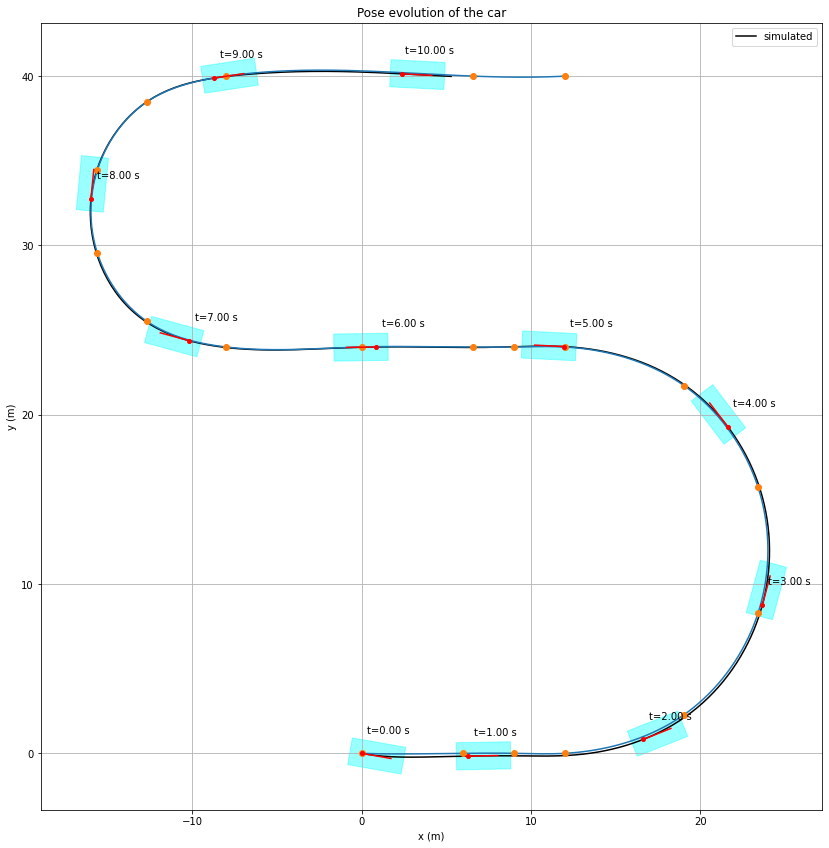

In [8]:
_,ax = plt.subplots(figsize=(14,16))
plant_simulator.viz_pose(ax=ax)
my_curve.viz(ax=ax)
ax.legend()
# ax.set_xlim([-3.0, 2.0])
ax.set_title(f"Pose evolution of the car")
for t in np.arange(0,sim_duration, 1.0): # snapshot at every X sec
    ind = int( np.argwhere(plant_simulator.t_sim_ev >= t)[0] ) # show snapshot (roughly) by every 3.0 sec
    footprint.draw_pose(
        X    = plant_simulator.X[ind,0],
        Y    = plant_simulator.X[ind,1],
        theta= plant_simulator.X[ind,2], 
        ax=ax, show_x_axis=True
    )
    plt.text(
        plant_simulator.X[ind,0]+1.6, 
        plant_simulator.X[ind,1]+1.2,
        f't={plant_simulator.t_sim_ev[ind]:2.2f} s',
        ha='center'
    )
plt.show()

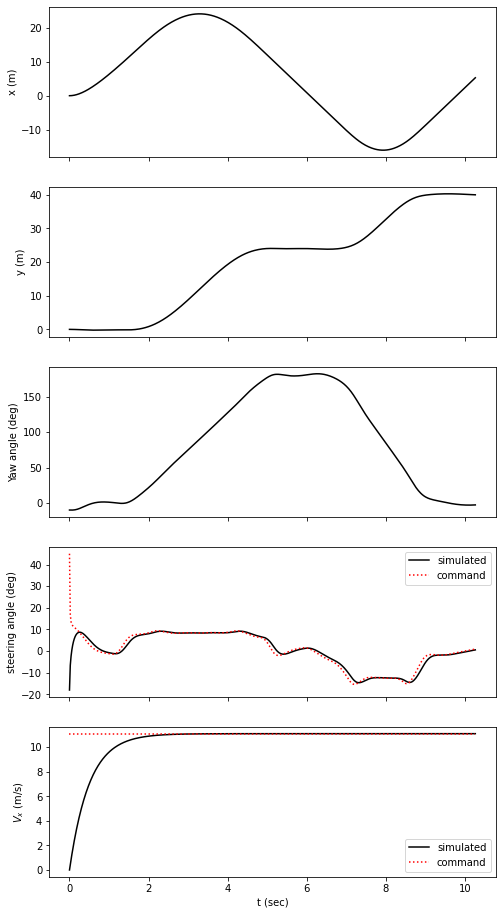

In [9]:
fig, axs = plt.subplots(5,1, sharex=True, figsize=(8,16))
plant_simulator.viz_trace(axs)
plt.show()

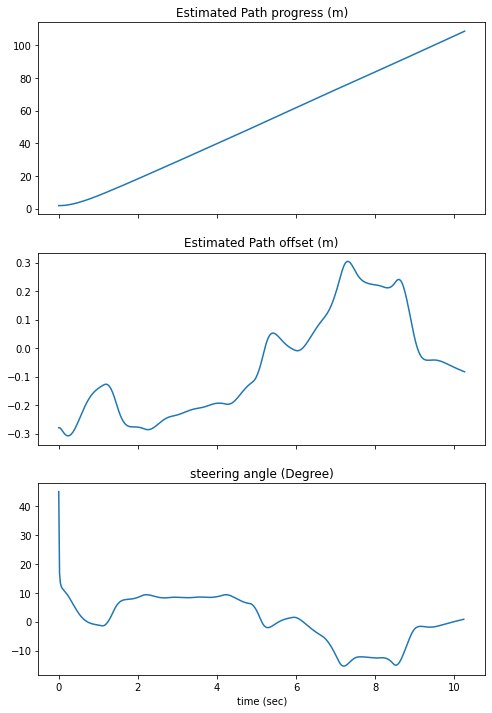

In [10]:
_, axs = plt.subplots(3,1,sharex=True, figsize=(8,12))


ax = axs[0]
ax.plot(plant_simulator.t_sim_ev, sim_data_Frenet_coordinate[:,0],label="simulation") # close to the set speed!
ax.set_title("Estimated Path progress (m)")

ax = axs[1]
ax.plot(plant_simulator.t_sim_ev, sim_data_Frenet_coordinate[:,1])
ax.set_title("Estimated Path offset (m)")

ax = axs[2]
ax.plot(plant_simulator.t_sim_ev[:-1], np.rad2deg(plant_simulator.U[:,0]))
ax.set_title("steering angle (Degree)")

axs[2].set_xlabel("time (sec)")
plt.show()